<a href="https://colab.research.google.com/github/Patric/fkd-gs/blob/master/notebooks/FakeNewsDetectionGraphSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news detection using graph solutions

This notebook is a walkthrough feature selection process and machine learning effects of Fake news detection using graph solution Master's Thesis.

First launch Dataset loading with 15 hidden cells,
then feature selection and testing classifiers can be launched independetly - just needs setting prerequisites section


To prevent disconencting paste the following script into your browser's console:
```
function ClickConnect() {
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect, 60000)

```

# Code formatting
Use !black command once to format the code, then use F5 and then save. Uncomment when needed

In [ ]:
# ! pip install black[jupyter]

In [ ]:
# !black /content/drive/MyDrive/ColabNotebooks/FakeNewsDetectionGraphSolutions.ipynb

# Dataset loading

## Mount google drive with processed features and define dataset paths

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


### Import libs for operating on datasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from enum import Enum

### Set datasets paths variables and map column names to features

Warning!!! These are Colab based paths. As for now data should be saved to your google drive from https://drive.google.com/drive/folders/1HOEIyiiFBALoqrHN5Jh8RczkvMIgUVyH?usp=sharing
 Paths should be adjusted accordingly

In [3]:
# variable should be adjusted according to your google drive TODO: figure out how to bond datasets more simply
features_directory_path = "/content/drive/MyDrive/FakeNewsDetectonColabNotebooks/resources/features"

politifact_more_than_1_relation_path = (
    f"{features_directory_path}/politifact_more_than_1_relation/"
)
politifact_all_path = f"{features_directory_path}/politifact_all/"
gossipcop_path = f"{features_directory_path}/gossipcop/"

e13_followers_path = f"{features_directory_path}/MIB/E13/"
fsf_followers_path = f"{features_directory_path}/MIB/FSF/"
int_followers_path = f"{features_directory_path}/MIB/INT/"
twt_followers_path = f"{features_directory_path}/MIB/TWT/"
tfp_followers_path = f"{features_directory_path}/MIB/TFP/"

In [4]:
features_files_names = [
    "eigenvector_to_label.csv",
    "harmonic_closeness_to_label.csv",
    "hits_to_label.csv",
    "betweenness_to_label.csv",
    "closeness_to_label.csv",
    "page_rank_to_label.csv",
    "article_rank_to_label.csv",
    "degree_to_label.csv",
]

class FeatureColumnName(Enum):
  EIGENVECTOR = 'eigenvector_score'
  HARMONIC_CLOSENESS = 'harmonic_closeness_centrality'
  CLOSENESS = 'closeness_score'
  HITS_HUB = 'hits_hub'
  HITS_AUTH = 'hits_auth'
  BETWEENNESS = 'betweenness_score'
  PAGE_RANK = 'page_rank_score'
  ARTICLE_RANK = 'article_rank_score'
  OUT_DEGREE = 'outDegree'
  IN_DEGREE = 'inDegree'
  DEGREE = 'degree'

## Define util functions

In [5]:
def get_data_frame(*paths):
    paths = list(sum(paths, []))
    dfs = list(map(lambda path: pd.read_csv(path), paths))
    df = pd.concat(dfs, join="outer", axis=1)
    df = df.loc[:, ~df.columns.duplicated()].copy()
    return df


def get_feature_full_path(data_set_path, feature_data):
    return f"{data_set_path}{feature_data}"


def get_features_paths(data_set_path, features_files):
    return list(
        map(
            lambda feature_file: get_feature_full_path(data_set_path, feature_file),
            features_files,
        )
    )

In [6]:
# split into dependend and independent variables
def split_into_X_y(data_frame, dependent_variables_list, independend_variable):
  X = data_frame[dependent_variables_list]
  y = data_frame[independend_variable]

  return X, y

## Convert datasets to Pandas DataFrames

In [7]:
paths_array = [e13_followers_path, fsf_followers_path, int_followers_path, twt_followers_path, tfp_followers_path]
mib_combined = list(map(lambda dataset_path: get_data_frame(get_features_paths(dataset_path, features_files_names)), paths_array))
dfs_mib_combined = pd.concat(mib_combined)

In [8]:
df_politifact = get_data_frame(get_features_paths(politifact_all_path, features_files_names))
df_politifact_more_than_1_relation = get_data_frame(get_features_paths(politifact_more_than_1_relation_path, features_files_names))

df_gossipcop = get_data_frame(get_features_paths(gossipcop_path, features_files_names))

df_fake_news_net_skeleton_combined = pd.concat([df_politifact, df_gossipcop])

In [9]:
datasets = {
    'politifact': df_politifact,
    'gossipcop': df_gossipcop,
    # fake_news_skeleton_combined = politifact + gossipcop
    'fake_news_skeleton_combined': df_fake_news_net_skeleton_combined,
    'mib_combined': dfs_mib_combined,
    'mib_combined_at_least_1_degree': dfs_mib_combined.copy().query('degree >= 1')
}

# Feature selection


## Set prerequisites

### Import libs for feature selection

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from IPython.display import display
import seaborn as sns

### Define feature selection **functions**

In [11]:
def select_features_chi2(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=chi2, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    row = []
    row.append(fs.scores_[i])
    if hasattr(fs, 'pvalues_'):
      row.append(fs.pvalues_[i])
      results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['Chi2 scores', 'Chi2 pvalues'], index=feature_names)

In [12]:
def select_features_f(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=f_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['F-test scores', 'F-test pvalues'], index=feature_names)

In [13]:
def select_features_mutual_info(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=mutual_info_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Mutual info scores'], index=feature_names)

In [14]:
def select_features_r(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=r_regression, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Pearson scores'], index=feature_names)

In [15]:
def tree_classifier(X, y):
  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X, y)
  feature_names = []
  scores = []
  for i in range(len(clf.feature_importances_)):
    feature_names.append(clf.feature_names_in_[i])
    scores.append([clf.feature_importances_[i]])

  return pd.DataFrame(scores, columns=['Tree classifier importances'], index=feature_names)

In [16]:
def plot_pearson_corr_matrix(data_frame, name):
  corr = data_frame.corr(method='pearson')
  plt.figure(figsize=(20, 10))
  # Increase the size of the 
  heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
  heatmap.set_title(f'{name} pearson correlation Heatmap', fontdict={'fontsize':12}, pad=12)
  plt.show()

In [17]:
def test_linear_regression_model(X_train, y_train, X_test, y_test):
  linreg=LinearRegression()
  linreg.fit(X_train,y_train)
  y_pred=linreg.predict(X_test)
  Accuracy=r2_score(y_test,y_pred)*100
  print(" Accuracy of the model is %.2f" %Accuracy)
  plt.scatter(y_test,y_pred)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()
  sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')
  plt.show()

In [35]:
def test_feature_dependency_for_dataset(df, df_name='Data frame'):
  features_included = [
          FeatureColumnName.EIGENVECTOR.value,
          FeatureColumnName.HARMONIC_CLOSENESS.value,
          FeatureColumnName.HITS_HUB.value,
          FeatureColumnName.HITS_AUTH.value,
          FeatureColumnName.BETWEENNESS.value,
          FeatureColumnName.CLOSENESS.value,
          FeatureColumnName.PAGE_RANK.value,
          FeatureColumnName.ARTICLE_RANK.value,
          FeatureColumnName.OUT_DEGREE.value,
          FeatureColumnName.IN_DEGREE.value,
          FeatureColumnName.DEGREE.value
          ]
  
  label_column_name = 'user.label'
  X, y = split_into_X_y(df, features_included, label_column_name)

  plot_pearson_corr_matrix(df, df_name)
  df_mi = select_features_mutual_info(X, y)
  df_f = select_features_f(X, y)
  df_chi2 = select_features_chi2(X, y)
  df_r = select_features_r(X, y)
  df_t =  tree_classifier(X, y)
  df_output = pd.concat([df_mi, df_f, df_chi2, df_r, df_t], axis=1)

  with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:.3f}'.format):
    display(df_output)

  print(f'Linear regression of features: {features_included}')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  test_linear_regression_model(X_train, y_train, X_test, y_test)

## Test feature dependency

### Select gossipcop features
In this case most significant features turned out to be page rank score and article score - page rank chosen as they were both correlated

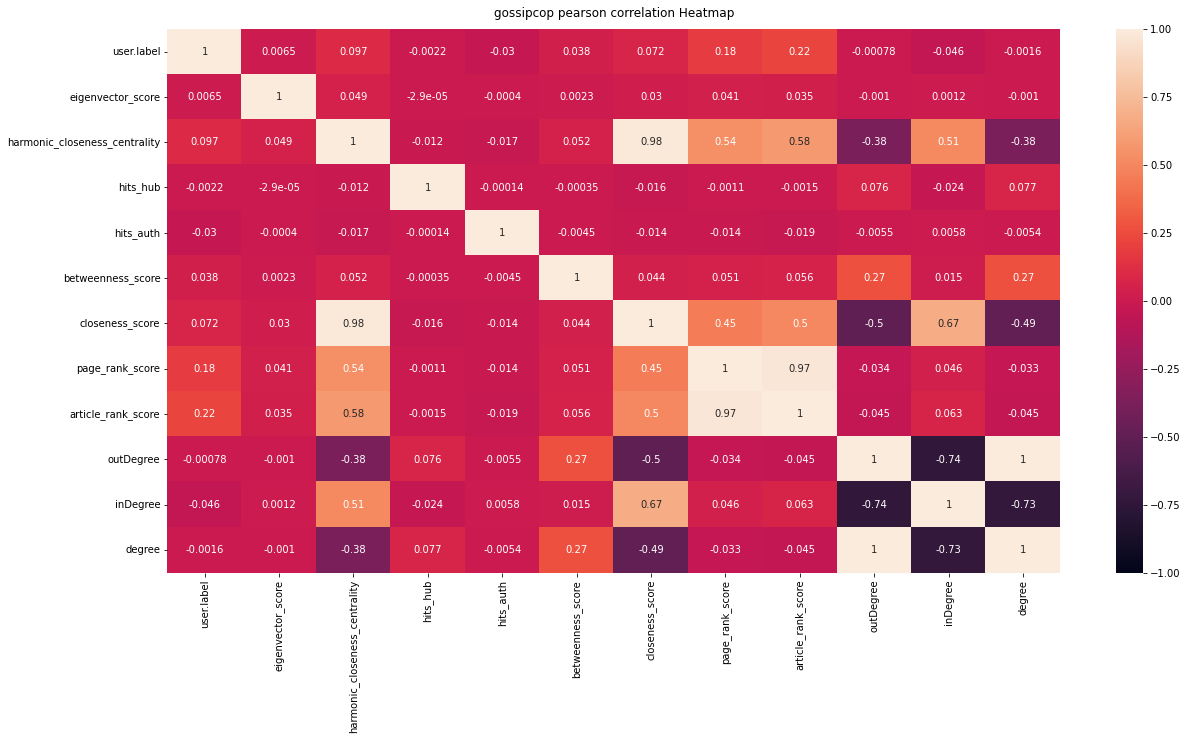

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.010,13.190,0.000,2.559,0.110,0.006,0.002
harmonic_closeness_centrality,0.011,2976.466,0.000,0.001,0.979,0.097,0.021
hits_hub,0.000,1.512,0.219,0.844,0.358,-0.002,0.000
hits_auth,0.012,282.384,0.000,11.521,0.001,-0.030,0.015
betweenness_score,0.008,445.080,0.000,12701.546,0.000,0.038,0.017
closeness_score,0.011,1637.603,0.000,0.000,0.988,0.072,0.028
page_rank_score,0.209,10651.680,0.000,69.852,0.000,0.181,0.404
article_rank_score,0.208,16389.056,0.000,23.628,0.000,0.223,0.459
outDegree,0.013,0.191,0.662,11.358,0.001,-0.001,0.025
inDegree,0.042,654.636,0.000,11.358,0.001,-0.046,0.003


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 7.95


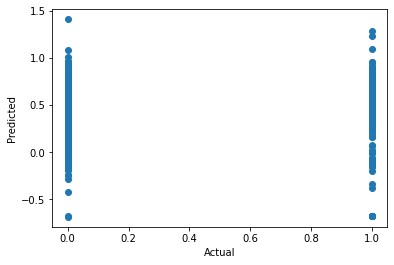

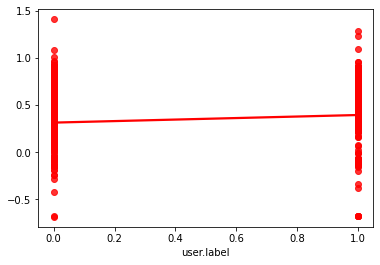

In [37]:
name = 'gossipcop'
test_feature_dependency_for_dataset(datasets[name], name)

### Select politifact features
Most significat features chosen: page rank based on correlation and betweenness based on chi2 test

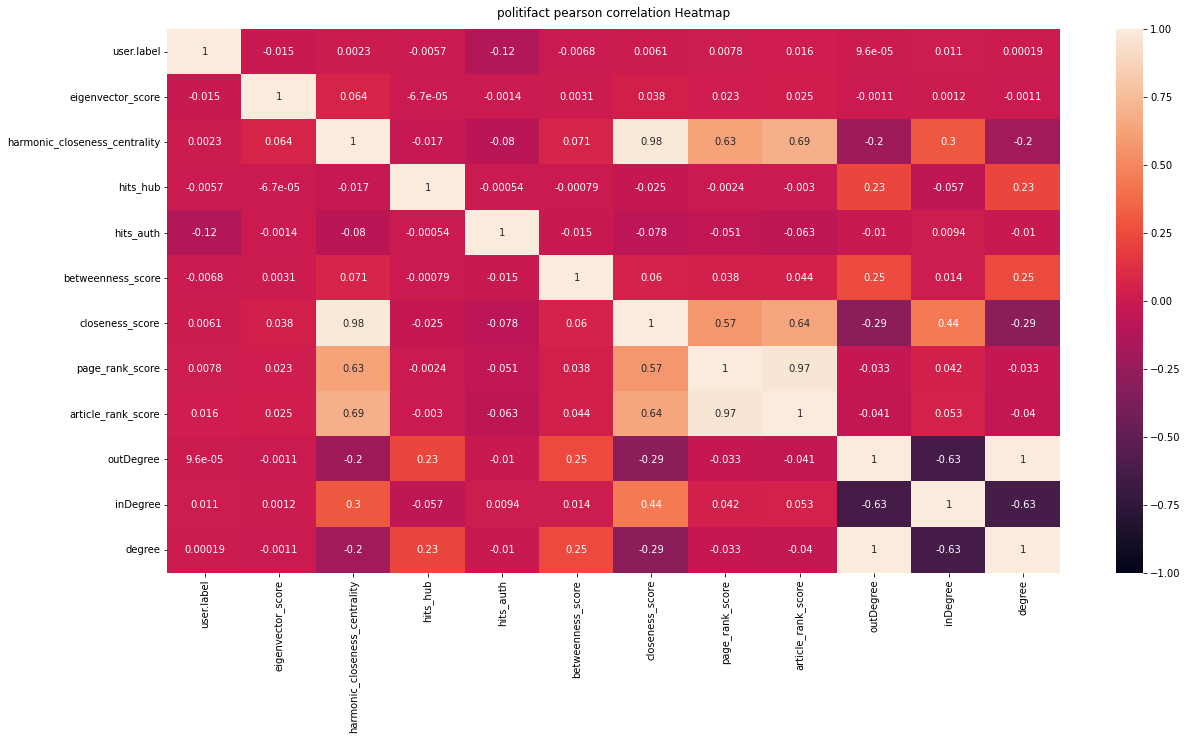

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.000,8.667,0.003,3.210,0.073,-0.015,0.001
harmonic_closeness_centrality,0.000,0.211,0.646,0.000,0.999,0.002,0.006
hits_hub,0.000,1.315,0.252,1.295,0.255,-0.006,0.000
hits_auth,0.022,607.285,0.000,27.472,0.000,-0.121,0.028
betweenness_score,0.000,1.873,0.171,74.700,0.000,-0.007,0.013
closeness_score,0.000,1.532,0.216,0.000,0.999,0.006,0.005
page_rank_score,0.563,2.527,0.112,0.037,0.847,0.008,0.461
article_rank_score,0.565,10.647,0.001,0.034,0.854,0.016,0.469
outDegree,0.000,0.000,0.984,0.036,0.850,0.000,0.008
inDegree,0.000,4.707,0.030,0.036,0.850,0.011,0.000


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 1.81


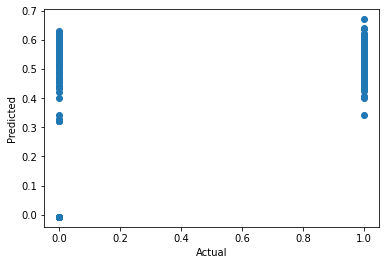

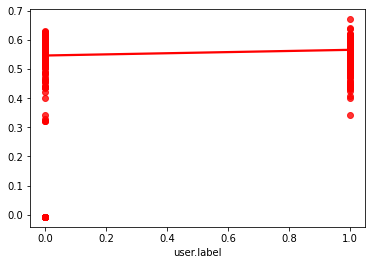

In [38]:
name = 'politifact'
test_feature_dependency_for_dataset(datasets[name], name)

### Select gossipcop + politifact features
Na podstawei tree classifier wybrany page rank, 

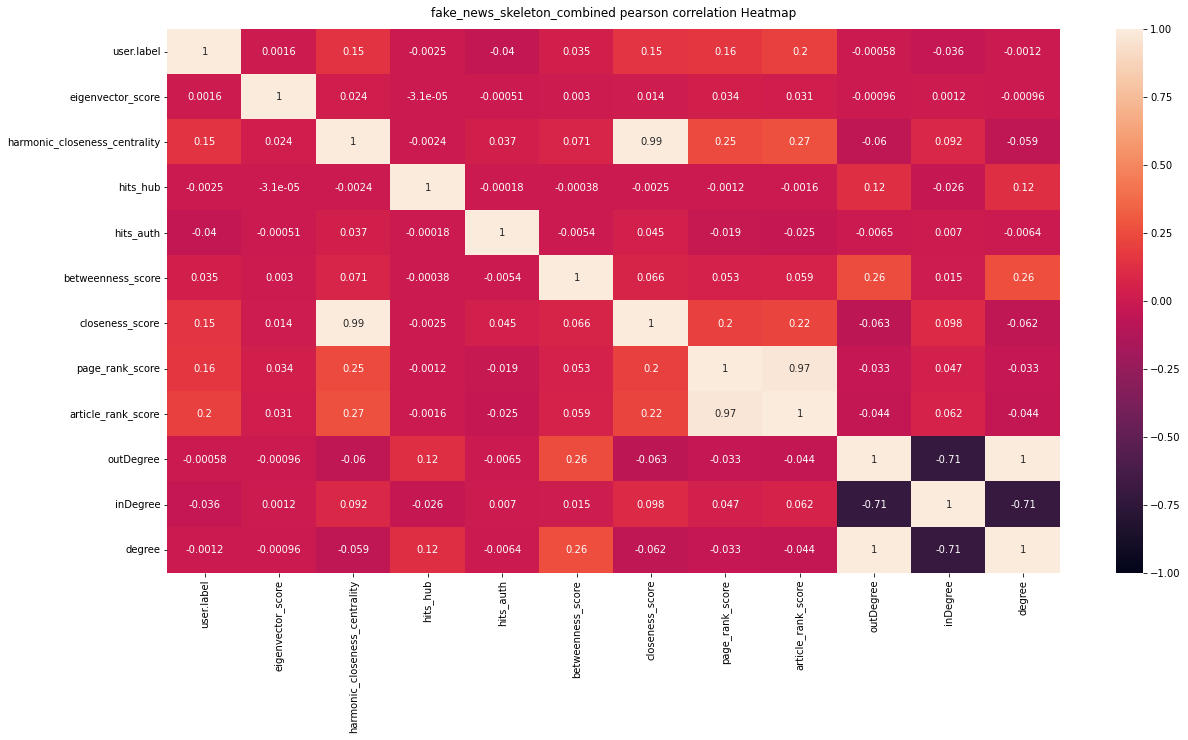

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.020,0.929,0.335,0.237,0.627,0.002,0.002
harmonic_closeness_centrality,0.020,7925.474,0.000,0.101,0.750,0.148,0.046
hits_hub,0.000,2.148,0.143,1.530,0.216,-0.002,0.000
hits_auth,0.011,583.671,0.000,25.271,0.000,-0.040,0.016
betweenness_score,0.009,438.670,0.000,13913.119,0.000,0.035,0.018
closeness_score,0.021,8073.976,0.000,0.086,0.770,0.149,0.047
page_rank_score,0.225,9778.541,0.000,74.900,0.000,0.164,0.386
article_rank_score,0.259,14958.180,0.000,25.026,0.000,0.201,0.445
outDegree,0.011,0.121,0.728,7.679,0.006,-0.001,0.018
inDegree,0.048,472.832,0.000,7.679,0.006,-0.036,0.003


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 8.03


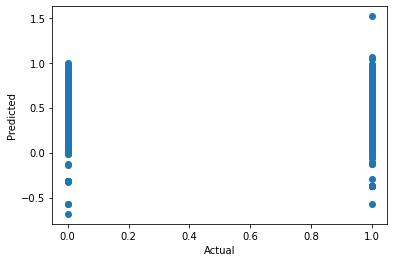

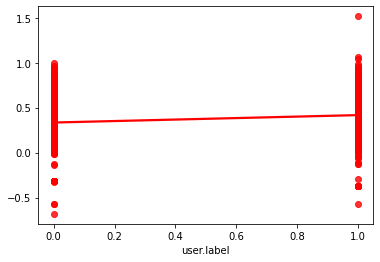

In [39]:
# politifact + gossipcop
name = 'fake_news_skeleton_combined'
test_feature_dependency_for_dataset(datasets[name], name)

### Select MIB combined user followers network features without users with only 1 degree

Harmonic closeness chosen as the only important feature based on correlation and tree classifier and eigenvector based on mutual information

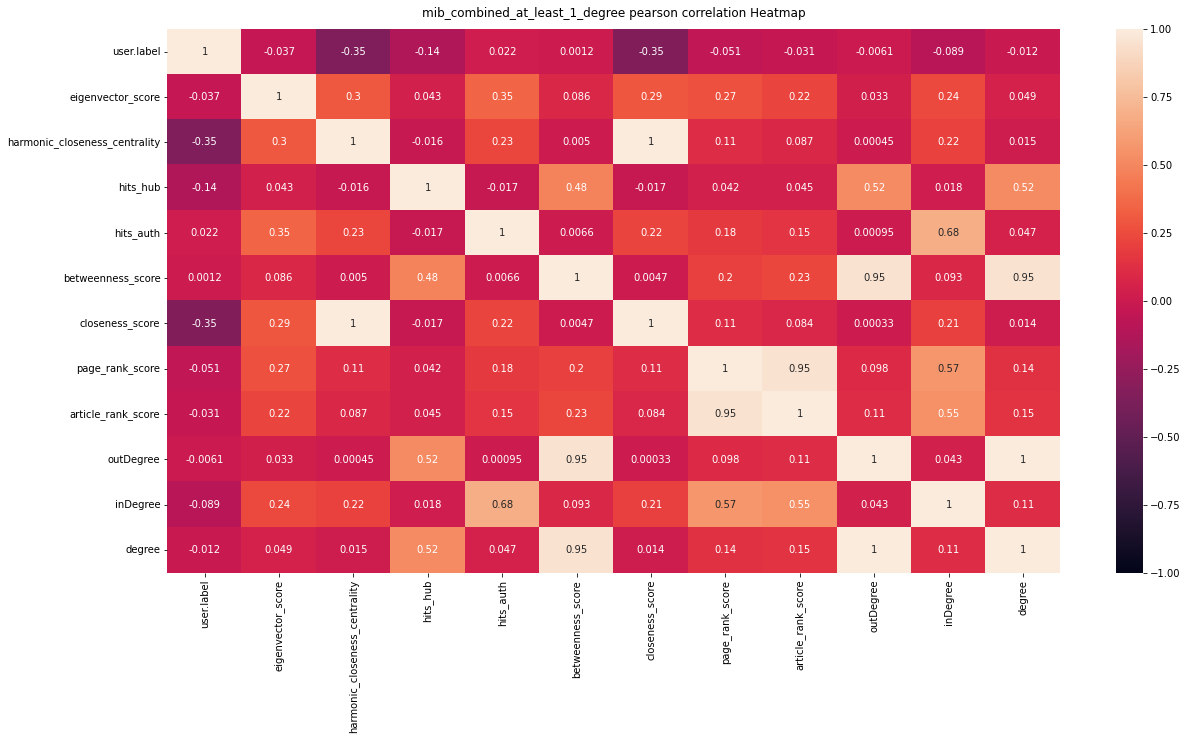

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.245,1950.344,0.000,9.942,0.002,-0.037,0.001
harmonic_closeness_centrality,0.271,196599.696,0.000,8538.933,0.000,-0.352,0.353
hits_hub,0.190,26842.827,0.000,981.298,0.000,-0.138,0.286
hits_auth,0.248,693.709,0.000,3.032,0.082,0.022,0.036
betweenness_score,0.002,2.082,0.149,4205253238.833,0.000,0.001,0.000
closeness_score,0.271,190243.421,0.000,7738.225,0.000,-0.347,0.289
page_rank_score,0.264,3580.209,0.000,22986.895,0.000,-0.051,0.000
article_rank_score,0.260,1308.763,0.000,708.467,0.000,-0.031,0.000
outDegree,0.114,51.639,0.000,3397591.733,0.000,-0.006,0.018
inDegree,0.178,11221.404,0.000,3397591.733,0.000,-0.089,0.007


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 25.20


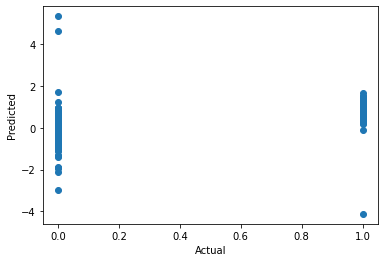

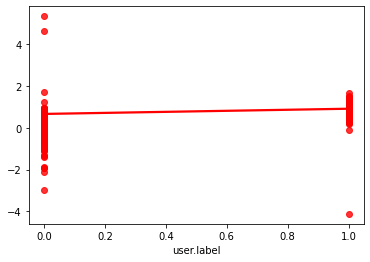

In [40]:
name = 'mib_combined_at_least_1_degree'
test_feature_dependency_for_dataset(datasets[name], name)

### Test all at once

In [ ]:
# for dataset_name in datasets:
#   print(f'Testing feature dependency for: {dataset_name}')
#   test_feature_dependency_for_dataset(datasets[dataset_name], dataset_name)

# Classifiers testing

## Set prerequisites

### Import libs for classifiers *testing*

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold

### Define test classifiers functions

In [ ]:
def test_classfiers(classifiers, X_train, X_test, y_train, y_test):
  log_cols = ["Classifier", "Accuracy", "Log Loss"]
  log = pd.DataFrame(columns=log_cols)

  for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("=" * 30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc * 100, ll]], columns=log_cols)
    log = log.append(log_entry)

  print("=" * 30)

## Politifact

### Test all classifiers and all features for Politifact

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['politifact'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

DecisionTreeClassifier
****Results****
Accuracy: 93.2538%
Log Loss: 0.9610326085682791
RandomForestClassifier
****Results****
Accuracy: 91.8899%
Log Loss: 0.2487523899704691
GradientBoostingClassifier
****Results****
Accuracy: 75.2314%
Log Loss: 0.48910976036714715
GaussianNB
****Results****
Accuracy: 57.1359%
Log Loss: 4.491868346396454
SVC
****Results****
Accuracy: 56.0156%
Log Loss: 0.6859459806243853
NuSVC
****Results****
Accuracy: 45.2752%
Log Loss: 0.6860208361254582
KNeighborsClassifier
****Results****
Accuracy: 88.9430%
Log Loss: 1.5073836380615684
AdaBoostClassifier
****Results****
Accuracy: 66.4637%
Log Loss: 0.6805810442908096
LinearDiscriminantAnalysis
****Results****
Accuracy: 57.2577%
Log Loss: 0.6769288743628294
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 60.6186%
Log Loss: 13.520030775009644


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Test best features and classifiers for Politifact

In [ ]:
features_included = [
        'betweenness_score',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['politifact'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3)
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

DecisionTreeClassifier
****Results****
Accuracy: 92.8154%
Log Loss: 0.8983340201077444
RandomForestClassifier
****Results****
Accuracy: 91.5246%
Log Loss: 0.24177377933226027
GradientBoostingClassifier
****Results****
Accuracy: 75.0122%
Log Loss: 0.48987015254805955
GaussianNB
****Results****
Accuracy: 55.0901%
Log Loss: 0.7835219958539461
KNeighborsClassifier
****Results****
Accuracy: 89.4301%
Log Loss: 1.4003050105374641


## Gossipcop

### Test all classifiers and all features for Gossipcop

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['gossipcop'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True)
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 75.6165%
Log Loss: 3.4808884365416284
DecisionTreeClassifier
****Results****
Accuracy: 79.3426%
Log Loss: 0.7403824377208762
RandomForestClassifier
****Results****
Accuracy: 79.0499%
Log Loss: 0.45925859780734213
AdaBoostClassifier
****Results****
Accuracy: 73.3700%
Log Loss: 0.6858544278203205
GradientBoostingClassifier
****Results****
Accuracy: 74.7574%
Log Loss: 0.5284798793773043
GaussianNB
****Results****
Accuracy: 34.4799%
Log Loss: 1.717303122043869
LinearDiscriminantAnalysis
****Results****
Accuracy: 68.1134%
Log Loss: 0.6174777214553016


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Results****
Accuracy: 34.2794%
Log Loss: 3.2159496901032987


### Test best classifiers and best features for Gossipcop

In [ ]:
features_included = [
        'page_rank_score',
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['gossipcop'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB(),

]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 76.0015%
Log Loss: 2.8912743382134996
DecisionTreeClassifier
****Results****
Accuracy: 79.2471%
Log Loss: 0.5181858679465262
RandomForestClassifier
****Results****
Accuracy: 79.2726%
Log Loss: 0.4363388786051571
GradientBoostingClassifier
****Results****
Accuracy: 73.8632%
Log Loss: 0.5416160259420387
GaussianNB
****Results****
Accuracy: 67.9479%
Log Loss: 0.817086078846829


## Gossipcop + Politifact

### Test best classifiers and bst features for Gossipcop + Politifact

In [ ]:
features_included = [
        # 'eigenvector_score',
        # 'harmonic_closeness_centrality',
        # 'hits_hub',
        # 'hits_auth',
        'betweenness_score',
        # 'closeness_score',
        'page_rank_score',
        # 'article_rank_score',
        # 'outDegree',
        # 'inDegree',
        # 'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_skeleton_combined'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  # SVC(kernel="rbf", C=0.025, probability=True),
  # NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  # AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  # LinearDiscriminantAnalysis(),
  # QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 74.4540%
Log Loss: 3.2557466232865124
DecisionTreeClassifier
****Results****
Accuracy: 78.6530%
Log Loss: 0.8141699899415096
RandomForestClassifier
****Results****
Accuracy: 78.4673%
Log Loss: 0.45840871944102757
GradientBoostingClassifier
****Results****
Accuracy: 71.6256%
Log Loss: 0.5611061643155209
GaussianNB
****Results****
Accuracy: 65.3298%
Log Loss: 0.8150149750193438


### Test all classifiers and all features for Gossipcop + Politifact


In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'article_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_skeleton_combined'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 73.5619%
Log Loss: 3.3357769829974355
DecisionTreeClassifier
****Results****
Accuracy: 78.7712%
Log Loss: 0.5377895063011987
RandomForestClassifier
****Results****
Accuracy: 78.7712%
Log Loss: 0.43501297018131135
GradientBoostingClassifier
****Results****
Accuracy: 72.1322%
Log Loss: 0.5637456007427311
GaussianNB
****Results****
Accuracy: 65.2567%
Log Loss: 0.7872628089440324


## Test classifiers for MIB combined network of followers

### Test best classifiers for MIB combined and best features

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'page_rank_score',
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 95.3552%
Log Loss: 1.602136626766073
DecisionTreeClassifier
****Results****
Accuracy: 95.3653%
Log Loss: 0.0798058778755153
RandomForestClassifier
****Results****
Accuracy: 95.3653%
Log Loss: 0.08272299468811753
GradientBoostingClassifier
****Results****
Accuracy: 95.3653%
Log Loss: 0.07962475552597127
GaussianNB
****Results****
Accuracy: 89.9988%
Log Loss: 0.5457150036559276


### Test all classifiers for MIB combined and all features

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True)
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 99.4751%
Log Loss: 0.08682594909848944
DecisionTreeClassifier
****Results****
Accuracy: 99.6776%
Log Loss: 0.011619435067909174
RandomForestClassifier
****Results****
Accuracy: 99.6962%
Log Loss: 0.007851446565563386
AdaBoostClassifier
****Results****
Accuracy: 98.8496%
Log Loss: 0.4662155062091281
GradientBoostingClassifier
****Results****
Accuracy: 99.4959%
Log Loss: 0.013610146561689192
GaussianNB
****Results****
Accuracy: 11.2170%
Log Loss: 1.047393500427791
LinearDiscriminantAnalysis
****Results****
Accuracy: 91.1470%
Log Loss: 0.3228661505740681


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Results****
Accuracy: 88.9755%
Log Loss: 0.7292802177215236
